In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c
from scipy.special import jn
import time

In [2]:
def dielectric_stack_1D_FC(eps1, eps2, a, eps_ratio, G):
    xi = np.zeros(G.size, dtype = 'complex')
    with np.errstate(divide='ignore', invalid='ignore'):
            xi = np.where(G != 0, 1j/(a*G)*(1 - np.exp(-1j*G*a*eps_ratio))*(1/eps2 - 1/eps1), xi)  
    xi[np.where(G == 0)] = eps_ratio*(1/eps1 - 1/eps2) + 1/eps2   

    return xi

def circular_dielectric_rod_1D_FC(eps1, eps2, a, r, G, N):
    volume_fraction = np.pi*r**2/a**2
    if np.linalg.norm(G) != 0:
            xi = 2*volume_fraction*(1/eps1 - 1/eps2)*jn(1, np.linalg.norm(G)*r)/(np.linalg.norm(G)*r)
    else:
        xi = volume_fraction*(1/eps1 - 1/eps2) + 1/eps2   

    return xi

def reciprocal_lattice_vectors_2D(d1, d2, theta, N):
    b1 = 2*np.pi/d1*np.array([1, 1/np.tan(theta)])
    b2 = 2*np.pi/(d2*np.sin(theta))*np.array([0, 1])
    G = []
    for h in range(-(N-1), N):
        for k in range(-(N-1), N):
            if abs(h) + abs(k) <= (N-1):
                G.append(h * b1 + k * b2)
    
    return np.array(sorted(G, key=lambda v: np.linalg.norm(v)))

In [ ]:
# set parameters 
eps1 = 1
eps2 = 8
a = 1e-6
eps_ratio = 0.8
zs = np.linspace(0, 20e-6, 400)

Nk = 101
ks = np.linspace(0, np.pi/a, Nk)
N = 70

band_index = 0
k_plot = ks[20]

###############################################################################################################à
G = 2*np.pi/a*np.arange(-N, N+1)

epsilon_z = np.zeros_like(zs)
for i, z in enumerate(zs):
    z_mod = z % a  
    if z_mod < a*eps_ratio:
        epsilon_z[i] = eps1
    else:
        epsilon_z[i] = eps2

theta = np.zeros((2*N+1, 2*N+1), dtype = 'complex')
omegas = np.zeros((Nk, 2*N+1))


for i, k in enumerate(ks): 
    for n in np.arange(0, 2*N+1):
        delta_G = G[n] - G  
        xi = dielectric_stack_1D_FC(eps1, eps2, a, eps_ratio, delta_G)
        theta[n] = xi*(G[n]+k)*(G+k)  
    eigenvalues, eigenvectors = np.linalg.eig(theta)
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    if k == k_plot:
        sorted_eigenvectors_plot = sorted_eigenvectors
    omega = np.sqrt(np.real(sorted_eigenvalues))*c
    omegas[i] = omega

omegas_vacuum = c*ks
omegas_medium = c*ks/np.sqrt((eps_ratio*eps1+(1-eps_ratio)*eps2))

fig, ax = plt.subplots(ncols=2, figsize = (14,4))

normalized_k = k_plot*a/(np.pi)
normalized_ks = ks*a/(np.pi)
normalized_omegas = omegas[:, :4]*a/(2*np.pi*c)
normalized_omegas_vacuum = omegas_vacuum*a/(2*np.pi*c)
normalized_omegas_medium = omegas_medium*a/(2*np.pi*c)

ax[0].plot(normalized_ks, normalized_omegas)
ax[0].plot(normalized_ks, normalized_omegas_vacuum, color = 'black', label = "light line", linestyle = '--', alpha = 0.8)
ax[0].plot(normalized_ks, normalized_omegas_medium, color = 'grey', label = "light line in medium", linestyle = '--', alpha = 0.8)
ax[0].set_ylabel("$fa/c$")
ax[0].set_xlabel(r"$ka/\pi$ ")

Hs = []
for z in zs:
    u = np.sum(sorted_eigenvectors_plot[:, band_index]*np.exp(1j*G*z))
    H = np.exp(1j*k_plot*z)*u
    Hs = np.append(H, Hs)
Es = np.gradient(Hs)/epsilon_z
ax[1].plot(zs*1e6, np.real(Hs), color = 'red')
#ax[1].plot(zs*1e6, np.real(Es), color = 'darkorange')
#ax[1].plot(zs*1e6, epsilon_z)
#ax[1].set_ylabel("$|H|^2$")
ax[1].set_xlabel("$z$ [um]")
for i in range(20):
    ax[1].axvspan(a*i*1e6, (a*i + a*eps_ratio)*1e6, alpha=0.4, color='blue')
    ax[1].axvspan((a*i + a*eps_ratio)*1e6, (a*i + a)*1e6, alpha=0.4, color='green')

ax[0].plot(normalized_k, normalized_omegas[np.where(ks == k_plot), band_index], 'o', color = 'goldenrod', alpha = 0.8)
ax[0].legend()
plt.show()

In [ ]:
diels = []
for z in zs:
    diels = np.append(diels, 1/np.sum(dielectric_stack_1D_FC(eps1, eps2, a, eps_ratio, G)*np.exp(1j*G*z)))
plt.plot(zs*1e6, diels)
plt.plot(zs*1e6, epsilon_z)
#for i in range(10):
    #plt.axvspan(a*i*1e6, (a*i + a*eps_ratio)*1e6, alpha=0.4, color='blue')
    #plt.axvspan((a*i + a*eps_ratio)*1e6, (a*i + a)*1e6, alpha=0.4, color='green')
plt.show()

### 2D BANDSTRUCTURE

Execution time of the for loop: 152.886517 seconds


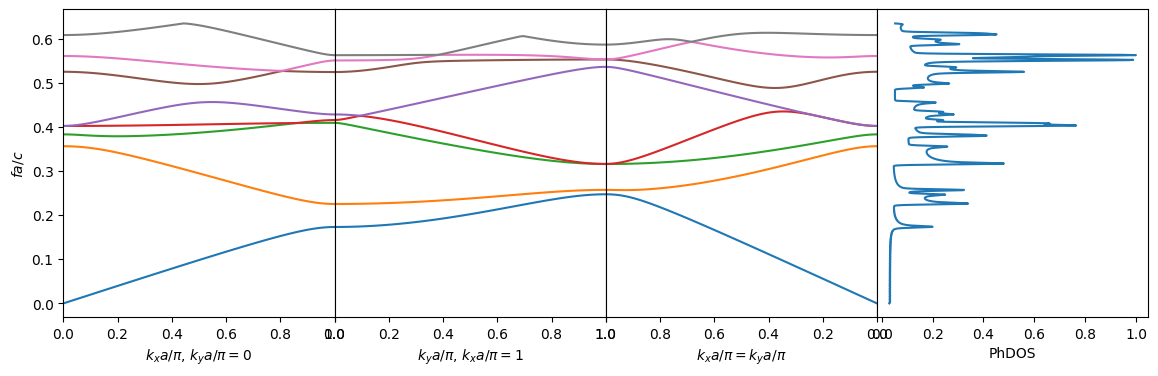

KeyboardInterrupt: 

In [8]:
# set parameters 
eps1 = 1
eps2 = 9
a = 1e-6
n_rs = 60
rs = np.linspace(a/4, a/2, n_rs)

Nk = 80
N = 10

threshold = 0.01
show_bands = 8

###############################################################################################################

kxs = np.concatenate([np.linspace(0, np.pi/a, Nk), np.pi/a*np.ones(Nk), np.linspace(np.pi/a, 0, Nk)])
kys = np.concatenate([np.zeros(Nk), np.linspace(0, np.pi/a, Nk), np.linspace(np.pi/a, 0, Nk)])
ks = np.stack((kxs, kys), axis=-1)
Gs = reciprocal_lattice_vectors_2D(a, a, np.pi/2, N)
Gs_prime = Gs.copy()

dim = int(1+(N)*2*(N-1))

edges = np.zeros((n_rs,2*(dim-1)))
for i1, r in enumerate(rs):
    start_time = time.perf_counter()
    theta = np.zeros((dim, dim), dtype = 'complex')
    omegas = np.zeros((int(ks.size/2), dim))
    for i, k in enumerate(ks): 
        for j1, G in enumerate(Gs):
            G_plus_k = G + k
            for j2, G_prime in enumerate(Gs_prime):
                delta_G = G - G_prime 
                xi = circular_dielectric_rod_1D_FC(eps1, eps2, a, r, delta_G, N)
                theta[j1, j2] = xi*np.dot(G_plus_k,G_prime+k)  
        eigenvalues, eigenvectors = np.linalg.eig(theta)
        sorted_indices = np.argsort(eigenvalues)
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        omegas[i] = np.sqrt(np.real(sorted_eigenvalues))*c

    normalized_ks = ks*a/(np.pi)
    normalized_omegas = omegas[:, :show_bands]*a/(2*np.pi*c)

    omega_min = np.min(normalized_omegas)
    omega_max = np.max(normalized_omegas)
    omega_range = np.linspace(omega_min, omega_max, 1000)
    eta = 0.002
    D_omega = np.zeros_like(omega_range)
    for omega_k_modes in normalized_omegas.T:
        for omega_k_val in omega_k_modes:
            D_omega += 1/(eta*np.sqrt(np.pi))*np.exp(-(omega_range - omega_k_val)**2/eta**2)

    D_omega = D_omega/np.max(D_omega)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Execution time of the for loop: {elapsed_time:.6f} seconds")

    fig, ax = plt.subplots(ncols=4, figsize = (14,4), sharey=True)

    ax[0].plot(normalized_ks[:Nk,0], normalized_omegas[:Nk])
    ax[1].plot(normalized_ks[Nk:2*Nk,1], normalized_omegas[Nk:2*Nk])
    ax[2].plot(normalized_ks[2*Nk:,0], normalized_omegas[2*Nk:])
    ax[0].set_ylabel("$fa/c$")
    ax[0].set_xlabel(r"$k_xa/\pi$, $k_ya/\pi = 0$ ")
    ax[1].set_xlabel(r"$k_ya/\pi$, $k_xa/\pi = 1$")
    ax[2].set_xlabel(r"$k_xa/\pi = k_ya/\pi$ ")
    ax2 = plt.gca()
    ax[2].set_xlim(ax2.get_xlim()[::-1])

    ax[0].set_xlim(0,1)
    ax[1].set_xlim(0,1)
    ax[2].set_xlim(1,0)
    ax[1].tick_params(axis='y', which='both', left=False, right=False)
    ax[2].tick_params(axis='y', which='both', left=False, right=False)
    ax[3].tick_params(axis='y', which='both', left=False, right=False)

    ax[3].plot(D_omega, omega_range)
    ax[3].set_xlabel("PhDOS")

    lower_edges = []
    upper_edges = []

    # Iterate through the DOS vector
    for idx in range(0,D_omega.size-1):
        if (D_omega[idx]>= threshold) and (D_omega[idx+1] <= threshold) :
            lower_edges.append(omega_range[idx])
        if (D_omega[idx] < threshold) and (D_omega[idx+1] >= threshold) :
            upper_edges.append(omega_range[idx])

    for i in range(len(lower_edges)):
        ax[0].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
        ax[1].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
        ax[2].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
        ax[3].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')

    edges[i1][:len(lower_edges) + len(upper_edges)] = np.sort(np.concatenate([lower_edges, upper_edges]))

    plt.subplots_adjust(wspace=0)
    plt.show()

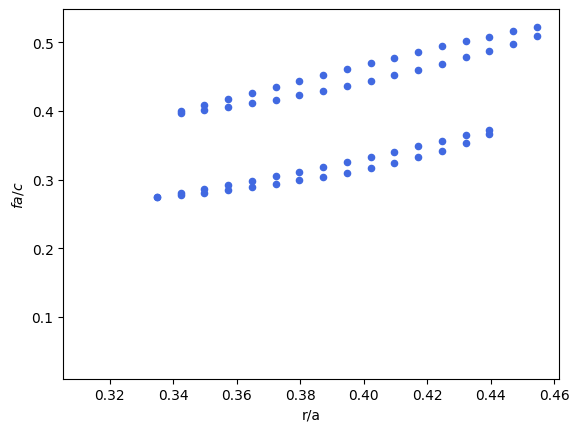

In [ ]:
for i in range(n_rs):
    plt.scatter(rs/a, edges.T[i], s = 20, color = "royalblue")
plt.ylim(0.01, None)
plt.xlabel("r/a")
plt.ylabel("$fa/c$")
plt.show()